# Input Data and Variables

In [293]:
import numpy as np
import os
import pandas as pd
import arcpy

# Import the required ArcGIS API for Python modules
import arcgis
from arcgis.gis import GIS
gis = arcgis.GIS()
from arcgis.geoanalytics import manage_data

from IPython.display import display, Markdown

In [294]:
dirWork         = os.getcwd()
dirInput        = os.path.join(dirWork, r'input'       )
dirIntermediate = os.path.join(dirWork, r'intermediate')
dirResults      = os.path.join(dirWork, r'results'     )
dirParams       = os.path.join(dirWork, r'params'      )

#read parameter tables
prmExclusions    = pd.read_csv(os.path.join(dirParams, r'exclusions.csv' ), parse_dates=['DATEFROM','DATETO'])
prmHolidays      = pd.read_csv(os.path.join(dirParams, r'holidays.csv'   ))
#prmGeographies   = pd.read_csv(os.path.join(dirParams, r'geographies.csv'))
prmStationGroups = pd.read_csv(os.path.join(dirParams, r'station_groups.csv'))

prmHolidays['DATE'] = pd.to_datetime(prmHolidays[['YEAR', 'MONTH', 'DAY']])



# Read in CCS Hour/Dir Volume Data

In [295]:
#import to csv
df_CCSHourDir = pd.read_csv(os.path.join(dirIntermediate, r'CCSHourDir_Combined_2013to2024.csv'))

In [296]:
#calculate date
df_CCSHourDir['DATE'] = pd.to_datetime(df_CCSHourDir[['YEAR', 'MONTH', 'DAY']])

#create index column for easy exlusion/holday
df_CCSHourDir = df_CCSHourDir.reset_index()
df_CCSHourDir

,index,STATION,YEAR,MONTH,DAY,DOW,HOUR,DIR,HOURVOL,DATE
0,0,301.0,2013,1,1,1,0,N,358,2013-01-01
1,1,301.0,2013,1,1,1,0,P,288,2013-01-01
2,2,301.0,2013,1,1,1,1,N,435,2013-01-01
3,3,301.0,2013,1,1,1,1,P,292,2013-01-01
4,4,301.0,2013,1,1,1,2,N,277,2013-01-01
...,...,...,...,...,...,...,...,...,...,...
20621209,20621209,733.0,2024,10,31,3,21,P,447,2024-10-31
20621210,20621210,733.0,2024,10,31,3,22,N,519,2024-10-31
20621211,20621211,733.0,2024,10,31,3,22,P,335,2024-10-31
20621212,20621212,733.0,2024,10,31,3,23,N,338,2024-10-31


In [297]:
df_CCSHourDir[(df_CCSHourDir['STATION']==341) & (df_CCSHourDir['YEAR']==2019) & (df_CCSHourDir['MONTH']==1)]

,index,STATION,YEAR,MONTH,DAY,DOW,HOUR,DIR,HOURVOL,DATE
5206569,5206569,341.0,2019,1,1,1,0,N,1185,2019-01-01
5206570,5206570,341.0,2019,1,1,1,0,P,1322,2019-01-01
5206571,5206571,341.0,2019,1,1,1,1,N,906,2019-01-01
5206572,5206572,341.0,2019,1,1,1,1,P,1074,2019-01-01
5206573,5206573,341.0,2019,1,1,1,2,N,640,2019-01-01
...,...,...,...,...,...,...,...,...,...,...
5207716,5207716,341.0,2019,1,31,3,21,P,2507,2019-01-31
5207717,5207717,341.0,2019,1,31,3,22,N,1572,2019-01-31
5207718,5207718,341.0,2019,1,31,3,22,P,1918,2019-01-31
5207719,5207719,341.0,2019,1,31,3,23,N,1012,2019-01-31


# Flag Rows that are Excluded from Analysis (exlusions and holidays)

## Mark Excluded Data

In [298]:
#exclusions
df_CCSHourDir['EXCLUDE'] = 0

df_CCSHourDirExclude = pd.DataFrame.merge(df_CCSHourDir,prmExclusions,on='STATION')
df_CCSHourDirExclude = df_CCSHourDirExclude[(df_CCSHourDirExclude['DATE']>=df_CCSHourDirExclude['DATEFROM']) & (df_CCSHourDirExclude['DATE']<=df_CCSHourDirExclude['DATETO'])]
lstExclude = df_CCSHourDirExclude['index'].to_list()

df_CCSHourDir.loc[df_CCSHourDir.index.isin(lstExclude), 'EXCLUDE'] = 1

#check number of records
df_CCSHourDir['EXCLUDE'].sum()

45120

## Mark Holiday Data

In [299]:
#holidays
df_CCSHourDir['HOLIDAY'] = 0

df_CCSHourDirHoliday = pd.DataFrame.merge(df_CCSHourDir,prmHolidays,on='DATE')
lstHoliday = df_CCSHourDirHoliday['index'].to_list()

df_CCSHourDir.loc[df_CCSHourDir.index.isin(lstHoliday), 'HOLIDAY'] = 1

#check number of records
df_CCSHourDir['HOLIDAY'].sum()

685499

In [300]:
display(df_CCSHourDir)

,index,STATION,YEAR,MONTH,DAY,DOW,HOUR,DIR,HOURVOL,DATE,EXCLUDE,HOLIDAY
0,0,301.0,2013,1,1,1,0,N,358,2013-01-01,0,1
1,1,301.0,2013,1,1,1,0,P,288,2013-01-01,0,1
2,2,301.0,2013,1,1,1,1,N,435,2013-01-01,0,1
3,3,301.0,2013,1,1,1,1,P,292,2013-01-01,0,1
4,4,301.0,2013,1,1,1,2,N,277,2013-01-01,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
20621209,20621209,733.0,2024,10,31,3,21,P,447,2024-10-31,0,0
20621210,20621210,733.0,2024,10,31,3,22,N,519,2024-10-31,0,0
20621211,20621211,733.0,2024,10,31,3,22,P,335,2024-10-31,0,0
20621212,20621212,733.0,2024,10,31,3,23,N,338,2024-10-31,0,0


In [301]:
display(df_CCSHourDir[df_CCSHourDir['YEAR']==2023])
display(df_CCSHourDir['HOUR'].dtype)

,index,STATION,YEAR,MONTH,DAY,DOW,HOUR,DIR,HOURVOL,DATE,EXCLUDE,HOLIDAY
161234,161234,301.0,2023,1,1,6,0,N,312,2023-01-01,0,1
161235,161235,301.0,2023,1,1,6,0,P,199,2023-01-01,0,1
161236,161236,301.0,2023,1,1,6,1,N,337,2023-01-01,0,1
161237,161237,301.0,2023,1,1,6,1,P,178,2023-01-01,0,1
161238,161238,301.0,2023,1,1,6,2,N,267,2023-01-01,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
20614155,20614155,733.0,2023,12,31,6,21,P,237,2023-12-31,0,0
20614156,20614156,733.0,2023,12,31,6,22,N,205,2023-12-31,0,0
20614157,20614157,733.0,2023,12,31,6,22,P,192,2023-12-31,0,0
20614158,20614158,733.0,2023,12,31,6,23,N,126,2023-12-31,0,0


dtype('int64')

# Calculate Daily Volumes

In [302]:
df_CCSHourDir_ExclusionsRemoved = df_CCSHourDir.loc[(df_CCSHourDir['EXCLUDE']==0) & (df_CCSHourDir['HOLIDAY']==0)]

df_CCSDay = df_CCSHourDir_ExclusionsRemoved.groupby(['STATION','YEAR','MONTH','DAY','DOW','DATE'],as_index=False).agg({'HOURVOL':[np.sum],'index':[np.size]})
df_CCSDay.columns = df_CCSDay.columns.droplevel(1)
df_CCSDay = df_CCSDay.rename(columns={'HOURVOL':'DAYVOL','index':'NUMREC'})
df_CCSDay
display(df_CCSDay[df_CCSDay['YEAR']==2022])

,STATION,YEAR,MONTH,DAY,DOW,DATE,DAYVOL,NUMREC
2994,301.0,2022,1,6,3,2022-01-06,28329,22
2995,301.0,2022,1,7,4,2022-01-07,59070,48
2996,301.0,2022,1,8,5,2022-01-08,56467,48
2997,301.0,2022,1,9,6,2022-01-09,48294,48
2998,301.0,2022,1,10,0,2022-01-10,54848,48
...,...,...,...,...,...,...,...,...
416291,733.0,2022,12,23,4,2022-12-23,558,4
416292,733.0,2022,12,26,0,2022-12-26,1046,4
416293,733.0,2022,12,27,1,2022-12-27,16337,28
416294,733.0,2022,12,28,2,2022-12-28,31929,48


# Calculate Time Of Day Volumes

In [303]:
dHrPrd = {
     'HOUR'  : [   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23],
     'PERIOD': ['EV','EV','EV','EV','EV','EV','AM','AM','AM','MD','MD','MD','MD','MD','MD','PM','PM','PM','EV','EV','EV','EV','EV','EV']
}

df_HrPrd = pd.DataFrame(dHrPrd)
display(df_HrPrd)

df_PrdCountHour = df_HrPrd.groupby(['PERIOD'],as_index=False).agg(HOURCOUNT=('HOUR','size'))
display(df_PrdCountHour)


,HOUR,PERIOD
0,0,EV
1,1,EV
2,2,EV
3,3,EV
4,4,EV
...,...,...
19,19,EV
20,20,EV
21,21,EV
22,22,EV


,PERIOD,HOURCOUNT
0,AM,3
1,EV,12
2,MD,6
3,PM,3


In [304]:
df_CCSHourDir_ExclusionsRemoved_wPrd = pd.merge(df_CCSHourDir_ExclusionsRemoved, df_HrPrd, on='HOUR', how='inner')
display(df_CCSHourDir_ExclusionsRemoved_wPrd)

df_CCSHour = df_CCSHourDir_ExclusionsRemoved_wPrd.groupby(['STATION','YEAR','MONTH','DAY','DOW','DATE','HOUR','PERIOD'],as_index=False).agg(HOURVOL=('HOURVOL','sum'),DIRCOUNT=('DIR','size'))
display(df_CCSHour)

df_CCSPeriod_AllData = df_CCSHour.groupby(['STATION','YEAR','MONTH','DAY','DOW','DATE','PERIOD'],as_index=False).agg(PERIODVOL=('HOURVOL','sum'),PKHRVOL=('HOURVOL','max'),NUMREC=('STATION','count'))
display(df_CCSPeriod_AllData)

#merge to only select time periods with full number of hours
df_CCSPeriod = pd.DataFrame.merge(df_CCSPeriod_AllData,df_PrdCountHour,left_on=('PERIOD','NUMREC'),right_on=('PERIOD','HOURCOUNT'),how='inner')
df_CCSPeriod = df_CCSPeriod.drop(columns=(['NUMREC','HOURCOUNT']))
#df_CCSPeriod['PKHRVOLPCTPRD'] = df_CCSPeriod['PKHRVOL'] / df_CCSPeriod['PERIODVOL']

display(df_CCSPeriod)

,index,STATION,YEAR,MONTH,DAY,DOW,HOUR,DIR,HOURVOL,DATE,EXCLUDE,HOLIDAY,PERIOD
0,48,301.0,2013,1,2,2,0,N,133,2013-01-02,0,0,EV
1,49,301.0,2013,1,2,2,0,P,130,2013-01-02,0,0,EV
2,96,301.0,2013,1,3,3,0,N,189,2013-01-03,0,0,EV
3,97,301.0,2013,1,3,3,0,P,166,2013-01-03,0,0,EV
4,144,301.0,2013,1,4,4,0,N,204,2013-01-04,0,0,EV
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19892078,20621117,733.0,2024,10,29,1,23,P,294,2024-10-29,0,0,EV
19892079,20621164,733.0,2024,10,30,2,23,N,276,2024-10-30,0,0,EV
19892080,20621165,733.0,2024,10,30,2,23,P,338,2024-10-30,0,0,EV
19892081,20621212,733.0,2024,10,31,3,23,N,338,2024-10-31,0,0,EV


,STATION,YEAR,MONTH,DAY,DOW,DATE,HOUR,PERIOD,HOURVOL,DIRCOUNT
0,301.0,2013,1,2,2,2013-01-02,0,EV,263,2
1,301.0,2013,1,2,2,2013-01-02,1,EV,195,2
2,301.0,2013,1,2,2,2013-01-02,2,EV,138,2
3,301.0,2013,1,2,2,2013-01-02,3,EV,147,2
4,301.0,2013,1,2,2,2013-01-02,4,EV,313,2
...,...,...,...,...,...,...,...,...,...,...
9968946,733.0,2024,10,31,3,2024-10-31,19,EV,1320,2
9968947,733.0,2024,10,31,3,2024-10-31,20,EV,1062,2
9968948,733.0,2024,10,31,3,2024-10-31,21,EV,1168,2
9968949,733.0,2024,10,31,3,2024-10-31,22,EV,854,2


,STATION,YEAR,MONTH,DAY,DOW,DATE,PERIOD,PERIODVOL,PKHRVOL,NUMREC
0,301.0,2013,1,2,2,2013-01-02,AM,8962,3795,3
1,301.0,2013,1,2,2,2013-01-02,EV,10791,3167,12
2,301.0,2013,1,2,2,2013-01-02,MD,17049,3045,6
3,301.0,2013,1,2,2,2013-01-02,PM,11802,4511,3
4,301.0,2013,1,3,3,2013-01-03,AM,8506,3618,3
...,...,...,...,...,...,...,...,...,...,...
1664131,733.0,2024,10,30,2,2024-10-30,PM,6689,2327,3
1664132,733.0,2024,10,31,3,2024-10-31,AM,3475,1392,3
1664133,733.0,2024,10,31,3,2024-10-31,EV,9028,1981,12
1664134,733.0,2024,10,31,3,2024-10-31,MD,11045,2248,6


,STATION,YEAR,MONTH,DAY,DOW,DATE,PERIOD,PERIODVOL,PKHRVOL
0,301.0,2013,1,2,2,2013-01-02,AM,8962,3795
1,301.0,2013,1,3,3,2013-01-03,AM,8506,3618
2,301.0,2013,1,4,4,2013-01-04,AM,8169,3503
3,301.0,2013,1,5,5,2013-01-05,AM,4962,2123
4,301.0,2013,1,6,6,2013-01-06,AM,3789,1646
...,...,...,...,...,...,...,...,...,...
1656131,733.0,2024,10,27,6,2024-10-27,PM,8428,3120
1656132,733.0,2024,10,28,0,2024-10-28,PM,7026,2386
1656133,733.0,2024,10,29,1,2024-10-29,PM,5863,2027
1656134,733.0,2024,10,30,2,2024-10-30,PM,6689,2327


# Calculate Month ADT

In [305]:
#average over month for each weekday
df_CCSMonthDOW = df_CCSDay.groupby(['STATION','YEAR','MONTH','DOW'],as_index=False).agg({'DAYVOL':[np.mean],'DATE':[np.size]})
df_CCSMonthDOW.columns = df_CCSMonthDOW.columns.droplevel(1)
df_CCSMonthDOW = df_CCSMonthDOW.rename(columns={'DAYVOL':'MONTHDOWADT','DATE':'NUMREC'})
#df_CCSMonthDOW['DOWVOL'] = df_CCSMonthDOW['DOWVOL'].astype(int)
df_CCSMonthDOW

display(df_CCSMonthDOW[df_CCSMonthDOW['YEAR']==2022])

,STATION,YEAR,MONTH,DOW,MONTHDOWADT,NUMREC
743,301.0,2022,1,0,55833.333333,3
744,301.0,2022,1,1,56405.333333,3
745,301.0,2022,1,2,59194.666667,3
746,301.0,2022,1,3,53267.750000,4
747,301.0,2022,1,4,62549.250000,4
...,...,...,...,...,...,...
107341,733.0,2022,12,2,27496.500000,4
107342,733.0,2022,12,3,32491.400000,5
107343,733.0,2022,12,4,23818.500000,4
107344,733.0,2022,12,5,29410.333333,3


In [306]:
#average over month for each weekday
df_CCSMonthDOWPeriod = df_CCSPeriod.groupby(['STATION','YEAR','MONTH','DOW','PERIOD'],as_index=False).agg(PERIODVOL=('PERIODVOL','mean'),PKHRVOL=('PKHRVOL','mean'),NUMREC=('DATE','size'))
df_CCSMonthDOWPeriod

display(df_CCSMonthDOWPeriod[df_CCSMonthDOWPeriod['YEAR']==2022])

,STATION,YEAR,MONTH,DOW,PERIOD,PERIODVOL,PKHRVOL,NUMREC
2972,301.0,2022,1,0,AM,10756.333333,4443.333333,3
2973,301.0,2022,1,0,EV,10962.000000,3137.333333,3
2974,301.0,2022,1,0,MD,20473.666667,3810.333333,3
2975,301.0,2022,1,0,PM,13641.333333,4800.333333,3
2976,301.0,2022,1,1,AM,10635.000000,4439.666667,3
...,...,...,...,...,...,...,...,...
428570,733.0,2022,12,5,PM,6558.666667,2287.666667,3
428571,733.0,2022,12,6,AM,1791.000000,920.000000,1
428572,733.0,2022,12,6,EV,4760.000000,1106.000000,1
428573,733.0,2022,12,6,MD,11826.000000,2379.000000,1


In [307]:
#average month dow
df_CCSMonthADT = df_CCSMonthDOW.groupby(['STATION','YEAR','MONTH'],as_index=False).agg({'MONTHDOWADT':[np.mean],'DOW':[np.size]})
df_CCSMonthADT.columns = df_CCSMonthADT.columns.droplevel(1)
df_CCSMonthADT = df_CCSMonthADT.rename(columns={'MONTHDOWADT':'MONTHADT','DOW':'NUMDOW'})
#df_CCSMonthADT['MONTHADT'] = df_CCSMonthADT['MONTHADT'].astype(int)

#only keep months with all 7 DOWs
df_CCSMonthADT = df_CCSMonthADT[df_CCSMonthADT['NUMDOW']==7]
df_CCSMonthADT

display(df_CCSMonthADT[df_CCSMonthADT['YEAR']==2022])

,STATION,YEAR,MONTH,MONTHADT,NUMDOW
107,301.0,2022,1,56537.369048,7
108,301.0,2022,3,70816.404762,7
109,301.0,2022,4,53110.619048,7
110,301.0,2022,5,58146.807143,7
111,301.0,2022,6,66867.797619,7
...,...,...,...,...,...
15670,733.0,2022,7,34222.638095,7
15671,733.0,2022,8,32868.321429,7
15672,733.0,2022,9,32572.569048,7
15673,733.0,2022,10,34307.050000,7


# Calculate Annual ADT

In [308]:
#average month dow
df_CCSYearADT = df_CCSMonthADT.groupby(['STATION','YEAR'],as_index=False).agg({'MONTHADT':[np.mean],'MONTH':[np.size]})
df_CCSYearADT.columns = df_CCSYearADT.columns.droplevel(1)
df_CCSYearADT = df_CCSYearADT.rename(columns={'MONTHADT':'YEARADT','MONTH':'NUMMONTH'})
#df_CCSYearADT['YEARADT'] = df_CCSYearADT['YEARADT'].astype(int)
display(df_CCSYearADT)

display(df_CCSYearADT['STATION'].unique())

display(df_CCSYearADT[(df_CCSYearADT['YEAR']==2022)])

,STATION,YEAR,YEARADT,NUMMONTH
0,301.0,2013,49525.395238,12
1,301.0,2014,51804.412302,12
2,301.0,2015,54572.420833,12
3,301.0,2016,59236.130952,12
4,301.0,2017,58353.828968,12
...,...,...,...,...
1534,732.0,2023,2086.920040,12
1535,732.0,2024,2088.258571,5
1536,733.0,2022,32613.830476,10
1537,733.0,2023,32901.812302,12


array([301., 302., 303., 304., 305., 306., 307., 308., 309., 310., 312.,
       313., 314., 315., 316., 317., 318., 319., 320., 321., 322., 323.,
       324., 325., 327., 329., 332., 333., 335., 340., 341., 348., 349.,
       350., 351., 353., 354., 355., 362., 363., 382., 400., 401., 402.,
       403., 404., 405., 406., 407., 408., 409., 411., 412., 414., 415.,
       416., 418., 420., 421., 424., 425., 427., 430., 431., 501., 502.,
       503., 504., 506., 507., 508., 509., 510., 511., 512., 513., 601.,
       602., 605., 606., 609., 611., 612., 613., 614., 615., 616., 617.,
       619., 620., 621., 622., 623., 624., 625., 626., 627., 628., 629.,
       630., 631., 632., 633., 634., 635., 636., 637., 638., 639., 640.,
       641., 642., 643., 644., 645., 646., 647., 648., 649., 650., 651.,
       653., 654., 655., 656., 657., 658., 659., 660., 661., 662., 663.,
       664., 665., 667., 668., 669., 670., 671., 672., 673., 674., 675.,
       676., 677., 678., 679., 680., 682., 702., 70

,STATION,YEAR,YEARADT,NUMMONTH
9,301.0,2022,63341.068333,10
21,302.0,2022,237601.314286,8
33,303.0,2022,9185.709524,10
45,304.0,2022,4162.788889,9
57,305.0,2022,4121.259127,6
...,...,...,...,...
1524,729.0,2022,10700.527513,9
1527,730.0,2022,3512.483069,9
1530,731.0,2022,1953.730423,9
1533,732.0,2022,2104.203439,9


In [309]:

#only keep years with all 12 months
df_CCSYearADT = df_CCSYearADT[df_CCSYearADT['NUMMONTH']==12]
display(df_CCSYearADT)

display(df_CCSYearADT['STATION'].unique())

,STATION,YEAR,YEARADT,NUMMONTH
0,301.0,2013,49525.395238,12
1,301.0,2014,51804.412302,12
2,301.0,2015,54572.420833,12
3,301.0,2016,59236.130952,12
4,301.0,2017,58353.828968,12
...,...,...,...,...
1525,729.0,2023,10636.232341,12
1528,730.0,2023,3148.104762,12
1531,731.0,2023,1808.985317,12
1534,732.0,2023,2086.920040,12


array([301., 302., 303., 304., 305., 306., 307., 308., 309., 310., 312.,
       313., 314., 315., 316., 317., 318., 319., 320., 321., 322., 323.,
       324., 325., 327., 329., 332., 333., 335., 340., 341., 348., 349.,
       350., 351., 353., 354., 355., 362., 363., 382., 400., 401., 402.,
       403., 404., 405., 406., 407., 408., 409., 411., 412., 414., 415.,
       416., 418., 420., 421., 424., 425., 427., 430., 431., 501., 502.,
       503., 504., 506., 507., 508., 509., 510., 511., 512., 513., 601.,
       602., 605., 606., 609., 611., 612., 613., 614., 615., 616., 617.,
       619., 620., 621., 622., 623., 624., 625., 626., 627., 628., 629.,
       630., 631., 632., 633., 634., 635., 636., 638., 639., 648., 649.,
       655., 660., 661., 665., 667., 668., 669., 671., 672., 673., 674.,
       675., 676., 678., 680., 682., 702., 703., 704., 711., 712., 713.,
       714., 715., 717., 718., 720., 721., 722., 724., 725., 726., 727.,
       728., 729., 730., 731., 732., 733.])

# Remove Data From Years that don't have atleast 12 months with 7 days of data

In [310]:
df_CCSYearADT
display(df_CCSYearADT[df_CCSYearADT['YEAR']==2022])

,STATION,YEAR,YEARADT,NUMMONTH


In [311]:
df_CCSDay_incompleteyearsremoved = pd.merge(df_CCSDay, df_CCSYearADT[['STATION','YEAR']], on=['STATION','YEAR'])
df_CCSDay_incompleteyearsremoved = df_CCSDay_incompleteyearsremoved.drop(columns=['NUMREC'])
display(df_CCSDay_incompleteyearsremoved)

df_CCSPeriod_incompleteyearsremoved = pd.merge(df_CCSPeriod, df_CCSYearADT[['STATION','YEAR']], on=['STATION','YEAR'])
#df_CCSPeriod_incompleteyearsremoved = df_CCSPeriod_incompleteyearsremoved.drop(columns=['NUMREC'])
display(df_CCSPeriod_incompleteyearsremoved)

,STATION,YEAR,MONTH,DAY,DOW,DATE,DAYVOL
0,301.0,2013,1,2,2,2013-01-02,48604
1,301.0,2013,1,3,3,2013-01-03,48287
2,301.0,2013,1,4,4,2013-01-04,51901
3,301.0,2013,1,5,5,2013-01-05,47536
4,301.0,2013,1,6,6,2013-01-06,36662
...,...,...,...,...,...,...,...
286867,733.0,2023,12,27,2,2023-12-27,38249
286868,733.0,2023,12,28,3,2023-12-28,38110
286869,733.0,2023,12,29,4,2023-12-29,41080
286870,733.0,2023,12,30,5,2023-12-30,37038


,STATION,YEAR,MONTH,DAY,DOW,DATE,PERIOD,PERIODVOL,PKHRVOL
0,301.0,2013,1,2,2,2013-01-02,AM,8962,3795
1,301.0,2013,1,3,3,2013-01-03,AM,8506,3618
2,301.0,2013,1,4,4,2013-01-04,AM,8169,3503
3,301.0,2013,1,5,5,2013-01-05,AM,4962,2123
4,301.0,2013,1,6,6,2013-01-06,AM,3789,1646
...,...,...,...,...,...,...,...,...,...
1144880,733.0,2023,12,27,2,2023-12-27,PM,9515,3246
1144881,733.0,2023,12,28,3,2023-12-28,PM,9587,3269
1144882,733.0,2023,12,29,4,2023-12-29,PM,9957,3415
1144883,733.0,2023,12,30,5,2023-12-30,PM,8694,3115


In [312]:
df_CCSMonthADT_incompleteyearsremoved = pd.merge(df_CCSMonthADT, df_CCSYearADT[['STATION','YEAR']], on=['STATION','YEAR'])
df_CCSMonthADT_incompleteyearsremoved = df_CCSMonthADT_incompleteyearsremoved.drop(columns=['NUMDOW'])
display(df_CCSMonthADT_incompleteyearsremoved)

df_CCSMonthDOWPeriod_incompleteyearsremoved = pd.merge(df_CCSMonthDOWPeriod, df_CCSYearADT[['STATION','YEAR']], on=['STATION','YEAR'])
df_CCSMonthDOWPeriod_incompleteyearsremoved = df_CCSMonthDOWPeriod_incompleteyearsremoved.drop(columns=['NUMREC'])
display(df_CCSMonthDOWPeriod_incompleteyearsremoved)

,STATION,YEAR,MONTH,MONTHADT
0,301.0,2013,1,44843.840476
1,301.0,2013,2,45251.178571
2,301.0,2013,3,46548.835714
3,301.0,2013,4,42423.921429
4,301.0,2013,5,43828.209524
...,...,...,...,...
10123,733.0,2023,8,33288.071429
10124,733.0,2023,9,33476.688095
10125,733.0,2023,10,35821.850000
10126,733.0,2023,11,34056.676190


,STATION,YEAR,MONTH,DOW,PERIOD,PERIODVOL,PKHRVOL
0,301.0,2013,1,0,AM,7607.333333,3153.666667
1,301.0,2013,1,0,EV,9191.333333,2626.000000
2,301.0,2013,1,0,MD,14126.666667,2660.000000
3,301.0,2013,1,0,PM,10296.000000,3854.000000
4,301.0,2013,1,1,AM,8555.500000,3525.500000
...,...,...,...,...,...,...,...
283563,733.0,2023,12,5,PM,7127.500000,2562.750000
283564,733.0,2023,12,6,AM,1684.750000,878.500000
283565,733.0,2023,12,6,EV,6206.000000,1527.250000
283566,733.0,2023,12,6,MD,12103.500000,2317.000000


In [313]:
df_CCSMonthDOWADT_incompleteyearsremoved = pd.merge(df_CCSMonthDOW, df_CCSYearADT[['STATION','YEAR']], on=['STATION','YEAR'])
df_CCSMonthDOWADT_incompleteyearsremoved = df_CCSMonthDOWADT_incompleteyearsremoved.drop(columns=['NUMREC'])
df_CCSMonthDOWADT_incompleteyearsremoved

,STATION,YEAR,MONTH,DOW,MONTHDOWADT
0,301.0,2013,1,0,41221.333333
1,301.0,2013,1,1,44297.000000
2,301.0,2013,1,2,47701.400000
3,301.0,2013,1,3,47551.400000
4,301.0,2013,1,4,47747.750000
...,...,...,...,...,...
70891,733.0,2023,12,2,30356.500000
70892,733.0,2023,12,3,33436.250000
70893,733.0,2023,12,4,35451.000000
70894,733.0,2023,12,5,31983.000000


In [314]:
display(df_CCSMonthDOWADT_incompleteyearsremoved[df_CCSMonthDOWADT_incompleteyearsremoved['YEAR']==2023])

,STATION,YEAR,MONTH,DOW,MONTHDOWADT
588,301.0,2023,1,0,55883.500000
589,301.0,2023,1,1,58312.200000
590,301.0,2023,1,2,42923.666667
591,301.0,2023,1,3,65418.500000
592,301.0,2023,1,4,58959.000000
...,...,...,...,...,...
70891,733.0,2023,12,2,30356.500000
70892,733.0,2023,12,3,33436.250000
70893,733.0,2023,12,4,35451.000000
70894,733.0,2023,12,5,31983.000000


# Export Results

In [315]:
df_CCSDay_incompleteyearsremoved.to_csv(os.path.join(dirIntermediate, 'DayVol.csv'),index=False)
df_CCSPeriod_incompleteyearsremoved.to_csv(os.path.join(dirIntermediate, 'DayPeriodVol.csv'),index=False)
df_CCSMonthADT_incompleteyearsremoved.to_csv(os.path.join(dirIntermediate, 'MonthADT.csv'),index=False)
df_CCSMonthDOWADT_incompleteyearsremoved.to_csv(os.path.join(dirIntermediate, 'MonthDOWADT.csv'),index=False)
df_CCSMonthDOWPeriod_incompleteyearsremoved.to_csv(os.path.join(dirIntermediate, 'MonthDOWPeriodVol.csv'),index=False)
df_CCSYearADT = df_CCSYearADT.drop(columns=['NUMMONTH'])
df_CCSYearADT.to_csv(os.path.join(dirIntermediate, 'YearADT.csv'),index=False)

# Visualize Results

In [316]:
#import arcgis libraries
from arcgis.gis import *
gis = GIS()

In [317]:
sdf_CCS = pd.DataFrame.spatial.from_featureclass(os.path.join(dirInput, r'UDOT\Continuous_Count_Station_Locations.shp'))
sdf_CCS

,FID,OBJECTID,LAYER_ID,ATR_NUMBER,ROUTE_NUMB,ROUTE_DIR_,START_ACCU,LOCTEXT,CNTY_NAME,LATITUDE,LONGITUDE,YEAR_EST,YEAR_DSC,CreationDa,Creator,EditDate,Editor,GlobalID,SENSOR1,STATION_N,Display,SHAPE
0,0,1,56,-0316,0089,1384,402.695,"SR 89 2 miles S of SR 193, Hillfield Road, L...",Davis,41.08467,-111.91104,1979,0,2020-12-14,psidwell@utah.gov_uplan,2020-12-14,psidwell@utah.gov_uplan,{9DFDBD97-1A89-4943-9290-84CF67EFD7D2},Loop,316,,"{""x"": -12457879.9855, ""y"": 5024838.501100004, ..."
1,1,2,56,-0407,0068,1368,038.593,"SR 68 2 miles N of Utah County Line, Bluffd...",Salt Lake,40.469218,-111.946136,1964,0,2020-12-14,psidwell@utah.gov_uplan,2020-12-14,psidwell@utah.gov_uplan,{0815834F-8933-4A39-ACF4-B71D02D35D36},NID,407,,"{""x"": -12461786.8558, ""y"": 4934363.883900002, ..."
2,2,3,56,-0506,0191,350,024.666,"SR 191 1.2 miles W of SR 163, Bluff MP 24.6...",San Juan,37.28168,-109.5681,1990,0,2020-12-14,psidwell@utah.gov_uplan,2020-12-14,psidwell@utah.gov_uplan,{C7863506-C7CB-4C37-9336-D5F7C94B1328},NID,506,,"{""x"": -12197065.098000001, ""y"": 4478442.413199..."
3,3,4,56,-0601,0092,1386,007.873,SR 92 American Fork Canyon W Toll Booth MP ...,Utah,40.43351,-111.74535,1999,0,2020-12-14,psidwell@utah.gov_uplan,2020-12-14,psidwell@utah.gov_uplan,{CE628122-9890-4150-9489-256DDC063224},Loop,601,,"{""x"": -12439435.4636, ""y"": 4929140.196999997, ..."
4,4,5,56,-0305,0024,1340,008.064,"SR 24 0.1 mile N of SR 118, Sigurd MP 8.06...",Sevier,38.86665,-111.96513,1939,0,2020-12-14,psidwell@utah.gov_uplan,2020-12-14,psidwell@utah.gov_uplan,{950CDBD5-13F0-4CA2-AF93-7D72B40B89BD},Loop,305,,"{""x"": -12463901.2559, ""y"": 4702588.284199998, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,181,182,0,-0729,0191,0,121.080,"LaSal Loop Rd via SR 191 - Millcreek Dr, Moab",Grand,38.523716,-109.498649,2020,0,2020-12-14,psidwell@utah.gov_uplan,2020-12-14,psidwell@utah.gov_uplan,{F7B62373-FD45-47C8-87D4-E4521B7A59CE},Proposed,729,,"{""x"": -12189333.865899999, ""y"": 4653675.813100..."
182,182,183,0,-0730,0012,0,0.750,"SR 89 Jct via SR 12 - SR 63, Bryce Cyn",Garfield,37.748634,-112.362904,2020,0,2020-12-14,psidwell@utah.gov_uplan,2020-12-14,psidwell@utah.gov_uplan,{364270AC-4FCF-4915-90C2-2EC82FBCF40F},Proposed,730,,"{""x"": -12508181.2661, ""y"": 4543976.8429000005,..."
183,183,184,0,-0731,0010,0,25.950,300 E Emery via SR 10 (Main St) - 100 S Millsi...,Emery,39.077101,-111.13179,2020,0,2020-12-14,psidwell@utah.gov_uplan,2020-12-14,psidwell@utah.gov_uplan,{89C01A88-B3E8-4D97-AA4F-B7946DA9FA93},Proposed,731,,"{""x"": -12371134.3015, ""y"": 4732721.7195999995,..."
184,184,185,0,-0732,0050,0,131.400,"300 S via SR 50 - SR 260, Scipio",Millard,39.238862,-112.103792,2020,0,2020-12-14,psidwell@utah.gov_uplan,2020-12-14,psidwell@utah.gov_uplan,{8612FEE7-EFC6-4CCF-80BD-BB08EC8AC5AC},Proposed,732,,"{""x"": -12479337.061, ""y"": 4755944.5145, ""spati..."


In [318]:
df_CCSSummary = df_CCSYearADT.groupby(['STATION'],as_index=False).agg({'YEAR':[np.size]})
df_CCSSummary.columns=('STATION_N','NUMYEARS')
df_CCSSummary
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(df_CCSSummary)
pd.set_option('display.max_rows', 10)

,STATION_N,NUMYEARS
0,301.0,8
1,302.0,6
2,303.0,6
3,304.0,8
4,305.0,8
5,306.0,9
6,307.0,8
7,308.0,9
8,309.0,7
9,310.0,8


In [319]:
print(sdf_CCS['STATION_N'].dtype)
print(df_CCSSummary['STATION_N'].dtype)


Int32
float64


In [320]:
df_CCSSummary['STATION_N'] = df_CCSSummary['STATION_N'].astype('Int32')


In [321]:
sdf_CCS_years = pd.DataFrame.merge(sdf_CCS,df_CCSSummary,on='STATION_N',how='left')


In [322]:
#display(sdf_CCS_years)
#display(sdf_CCS_years[sdf_CCS_years.isna().any(axis=1)])
nan_df = sdf_CCS_years[sdf_CCS_years.isna().any(axis=1)]
#display(nan_df)
nan_stations = nan_df['STATION_N'].unique().tolist()
#display(nan_stations)
nan_stations = sorted(nan_stations)
display(nan_stations)

[-1667,
 618,
 637,
 640,
 641,
 642,
 643,
 644,
 645,
 646,
 647,
 650,
 651,
 653,
 654,
 656,
 657,
 658,
 659,
 662,
 663,
 664,
 666,
 670,
 677,
 679,
 716,
 719,
 723,
 1637,
 1640,
 1648,
 1665,
 1668,
 1670,
 1672,
 1673,
 1674,
 2341,
 3341]

In [323]:
null_columns = sdf_CCS_years.columns[sdf_CCS_years.isnull().any()]
display(null_columns)

Index(['NUMYEARS'], dtype='object')

In [324]:
sdf_CCS_years['NUMYEARS'] = sdf_CCS_years['NUMYEARS'].fillna(0)
sdf_CCS_years['NUMYEARS'] = sdf_CCS_years['NUMYEARS'].astype(int)

In [325]:
print(sdf_CCS['STATION_N'].dtype)
print(df_CCSSummary['STATION_N'].dtype)


Int32
Int32


In [326]:
sdf_CCS_years.dtypes

FID                    Int64
OBJECTID               Int32
LAYER_ID               Int64
ATR_NUMBER    string[python]
ROUTE_NUMB    string[python]
                   ...      
SENSOR1       string[python]
STATION_N              Int32
Display       string[python]
SHAPE               geometry
NUMYEARS               int32
Length: 23, dtype: object

In [327]:
#create map1 with zoom set to Salt Lake (any city or place name can be used)
map1 = gis.map('Salt Lake')


#expression to classify enrollment

arcexp_ccs = ("var v = $feature.NUMYEARS;        "
              "if      (v==0) { return 'zero'  ;}"
              "else if (v==1) { return 'one'   ;}"
              "else if (v==2) { return 'two'   ;}"
              "else if (v==3) { return 'three' ;}"
              "else if (v==4) { return 'four'  ;}"
              "else if (v==5) { return 'five'  ;}"
              "else if (v==6) { return 'six'   ;}"
              "else if (v>=7) { return 'seven' ;}"
              "else           { return 'other' ;}")

#symbology for enrollment classes
unival_ccs = [
                {"value":"zero"  , "label":"No Years", "symbol":{"type":"esriSMS","style":"STYLE_SQUARE","color":[200,200,200,168],"size": "18px","outline":{"color":[255,255, 255],"width":1}}},
                {"value":"one"   , "label":"1 Year"  , "symbol":{"type":"esriSMS","style":"STYLE_SQUARE","color":[255,255,  0,168],"size": "18px","outline":{"color":[255,255, 255],"width":1}}},
                {"value":"two"   , "label":"2 Years" , "symbol":{"type":"esriSMS","style":"STYLE_SQUARE","color":[  0,255,255,168],"size": "18px","outline":{"color":[255,255, 255],"width":1}}},
                {"value":"three" , "label":"3 Years" , "symbol":{"type":"esriSMS","style":"STYLE_SQUARE","color":[  0,255,  0,168],"size": "18px","outline":{"color":[255,255, 255],"width":1}}},
                {"value":"four"  , "label":"4 Years" , "symbol":{"type":"esriSMS","style":"STYLE_SQUARE","color":[255,  0,255,168],"size": "18px","outline":{"color":[255,255, 255],"width":1}}},
                {"value":"five"  , "label":"5 Years" , "symbol":{"type":"esriSMS","style":"STYLE_SQUARE","color":[  0,  0,255,168],"size": "18px","outline":{"color":[255,255, 255],"width":1}}},
                {"value":"six"   , "label":"6 Years" , "symbol":{"type":"esriSMS","style":"STYLE_SQUARE","color":[  0,  0,192,168],"size": "18px","outline":{"color":[255,255, 255],"width":1}}},
                {"value":"seven" , "label":"7 Years" , "symbol":{"type":"esriSMS","style":"STYLE_SQUARE","color":[  0,  0,128,168],"size": "18px","outline":{"color":[255,255, 255],"width":1}}}
             ]

#define sdf layer
sdf_CCS_years.spatial.plot(map_widget = map1,
                           renderer_type     = 'u-a',
                           unique_values     = unival_ccs,
                           arcade_expression = arcexp_ccs,
                           default_symbol    = ""
                          )

map1.layout.height='600px'
map1.legend=True

#add map title
display(Markdown('<h2><center>CCS Number of Full Years of Data</center></h2>'))

#display the map
map1

<h2><center>CCS Number of Full Years of Data</center></h2>

MapView(layout=Layout(height='600px', width='100%'), legend=True)

# Chart Month ADT for Station

In [328]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

In [329]:
def roundup(x):
    if x > 10000:
        return x if x % 10000== 0 else x + 10000 - x % 10000
    else:
        return x if x % 1000== 0 else x + 1000 - x % 1000


IndexError: list index out of range

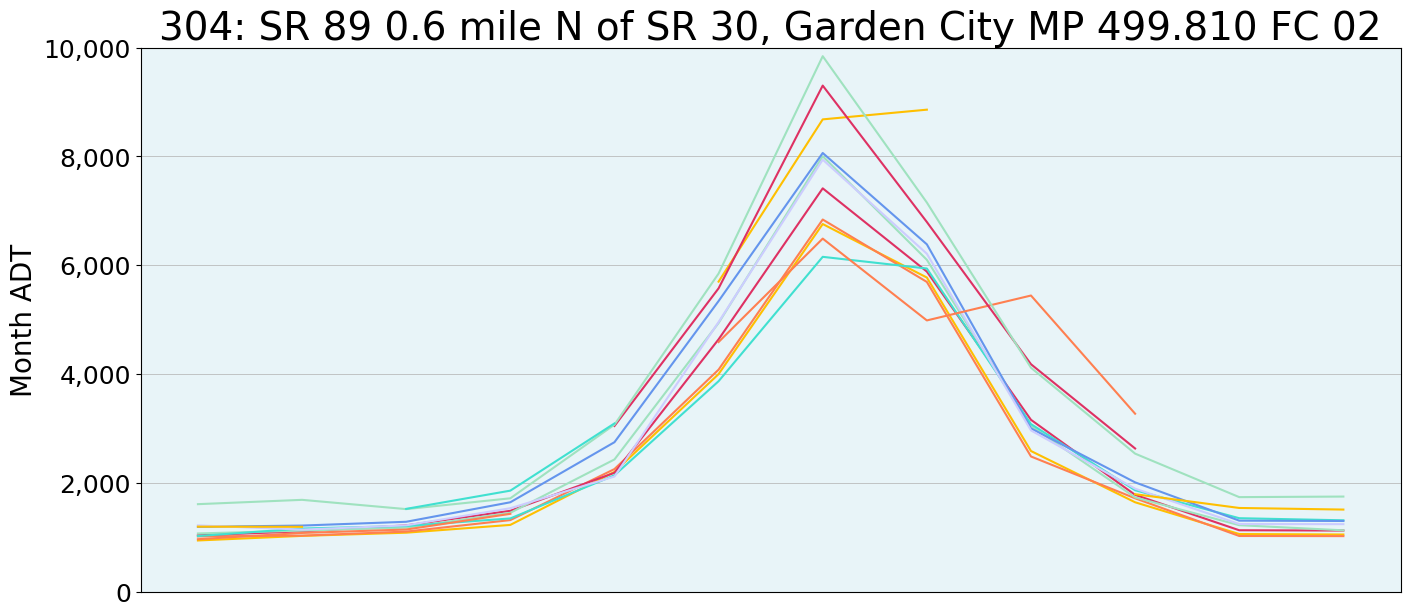

In [330]:
#Make Charts

stations = [304,305,306,307,308]

for station in stations:
    iStation = station
    dfStationData = prmStationGroups[prmStationGroups['STATIONGROUP']==str(iStation)]
    sStationName = dfStationData.iloc[0]['STATIONGROUPDESCRIPTION']

    dfPlot = df_CCSMonthADT[(df_CCSMonthADT['STATION']==iStation)]
    dfPlot = dfPlot[['YEAR','MONTH','MONTHADT']]
    dfPlot = dfPlot.pivot(index='MONTH', columns='YEAR', values='MONTHADT')
    #display(dfPlot)

    sLegend = dfPlot.columns.tolist()

    sColors = ["#FFBF00","#FF7F50","#DE3163","#9FE2BF","#40E0D0","#6495ED","#CCCCFF"]

    sBGColor = "#e8f4f8"

    aFigureSize = (18,8)
    iTitleSize = 28
    iLegendSize = 12
    iAxisItemSize = 18
    iAxisTitleSize = 20

    sXAxisLabel = ""
    sYAxisLabel = "Month ADT"

    ax = dfPlot.plot.line(figsize=aFigureSize, fontsize=iAxisItemSize, color=sColors, zorder=10)

    #set x,y labels
    ax.set_xlabel(sXAxisLabel, fontsize=iAxisTitleSize)
    ax.set_ylabel(sYAxisLabel, fontsize=iAxisTitleSize)

    sTitle = sStationName

    #set title
    ax.set_title(sTitle, fontsize=iTitleSize)
    #add title 
    #display(Markdown("# " + sTitle))

    ax.legend([sLegend], prop=dict(size=iLegendSize));

    ax.grid('on', which='major', axis='y', linestyle='-', linewidth=0.5, zorder=1)

    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

    ax.set_ylim([0, roundup(max(dfPlot.max(axis=1)))])

    ax.set_facecolor (sBGColor)

    # Add a table at the bottom of the axes

    #remove legend
    ax.get_legend().remove()

    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.2, bottom=0.2)
    plt.xticks([]) #remove x tick labels

    #setup table values, use T to transpose dataframe
    df_table = dfPlot.copy()
    df_table = df_table.applymap("{:,.0f}".format)
    df_table = df_table.T
    cellValues = df_table.values.tolist()

    #columnLabels = dfPlot.T.columns
    columnLabels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

    #create table and define attributes
    the_table = plt.table(cellText=cellValues,
                          rowLabels=sLegend,
                          rowColours=sColors,
                          colLabels=columnLabels,
                          rowLoc='right',
                          cellLoc='center',
                          loc='bottom')
    the_table.set_fontsize(iAxisItemSize)
    the_table.scale(1,1.8)


In [331]:
print("cellValues:", len(cellValues), cellValues)
print("sLegend:", len(sLegend), sLegend)
print("sColors:", len(sColors), sColors)
print("columnLabels:", len(columnLabels), columnLabels)


cellValues: 12 [['938', '1,022', '1,081', '1,224', '2,199', '3,996', '6,755', '5,771', '2,582', '1,640', '1,056', '1,048'], ['1,013', '1,027', '1,101', '1,313', '2,251', '4,078', '6,838', '5,691', '2,482', '1,713', '1,021', '1,018'], ['1,033', '1,106', '1,216', '1,483', '2,182', '4,636', '7,411', '5,881', '3,156', '1,777', '1,126', '1,120'], ['1,067', '1,120', '1,174', '1,446', '2,427', '4,936', '8,001', '6,097', '3,042', '1,729', '1,219', '1,125'], ['1,019', '1,157', '1,204', '1,343', '2,136', '3,866', '6,152', '5,937', '3,077', '1,861', '1,347', '1,309'], ['1,188', '1,212', '1,282', '1,640', '2,744', '5,339', '8,061', '6,382', '2,998', '2,006', '1,302', '1,296'], ['1,215', '1,137', '1,216', '1,531', '2,113', '4,953', '7,938', '6,209', '2,961', '1,891', '1,240', '1,238'], ['1,192', '1,189', 'nan', '1,632', 'nan', '5,696', '8,679', '8,857', 'nan', '1,789', '1,536', '1,506'], ['961', '1,076', '1,139', '1,428', 'nan', '4,586', '6,487', '4,983', '5,441', '3,268', 'nan', '1,921'], ['1,620'

# Chart Daily Volume

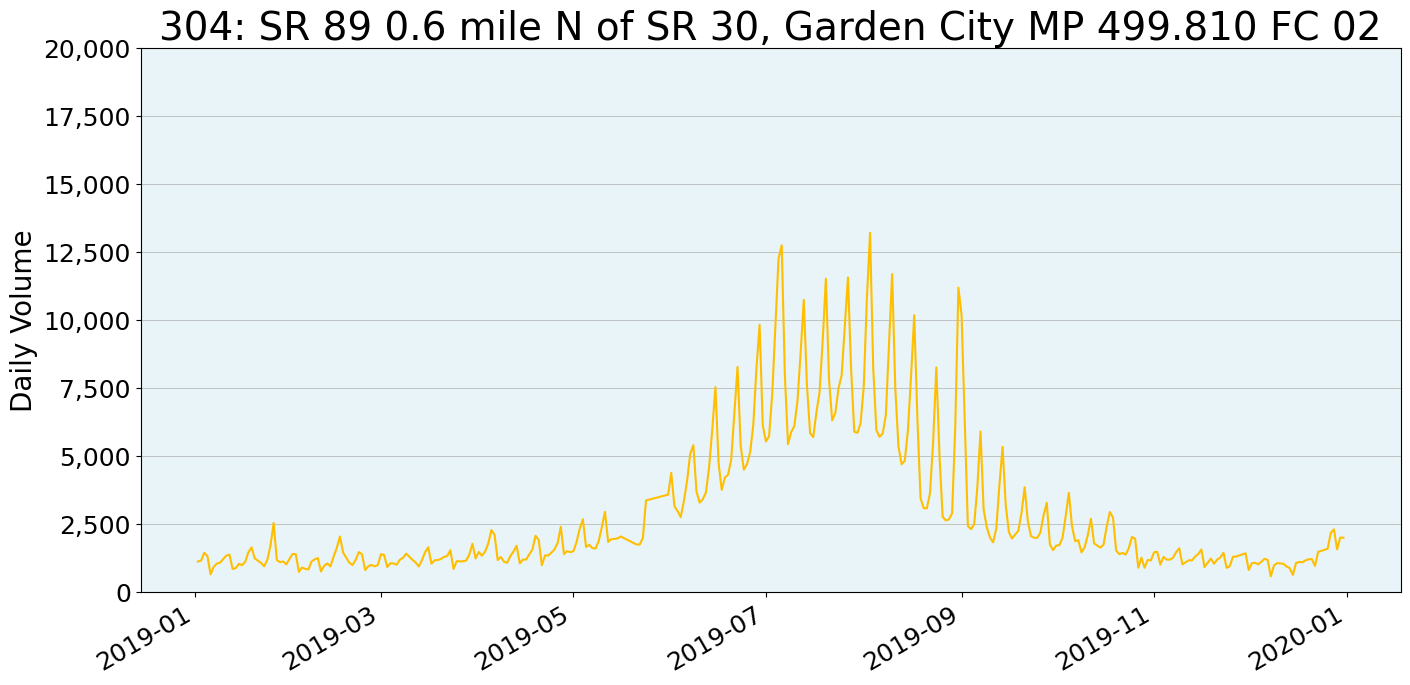

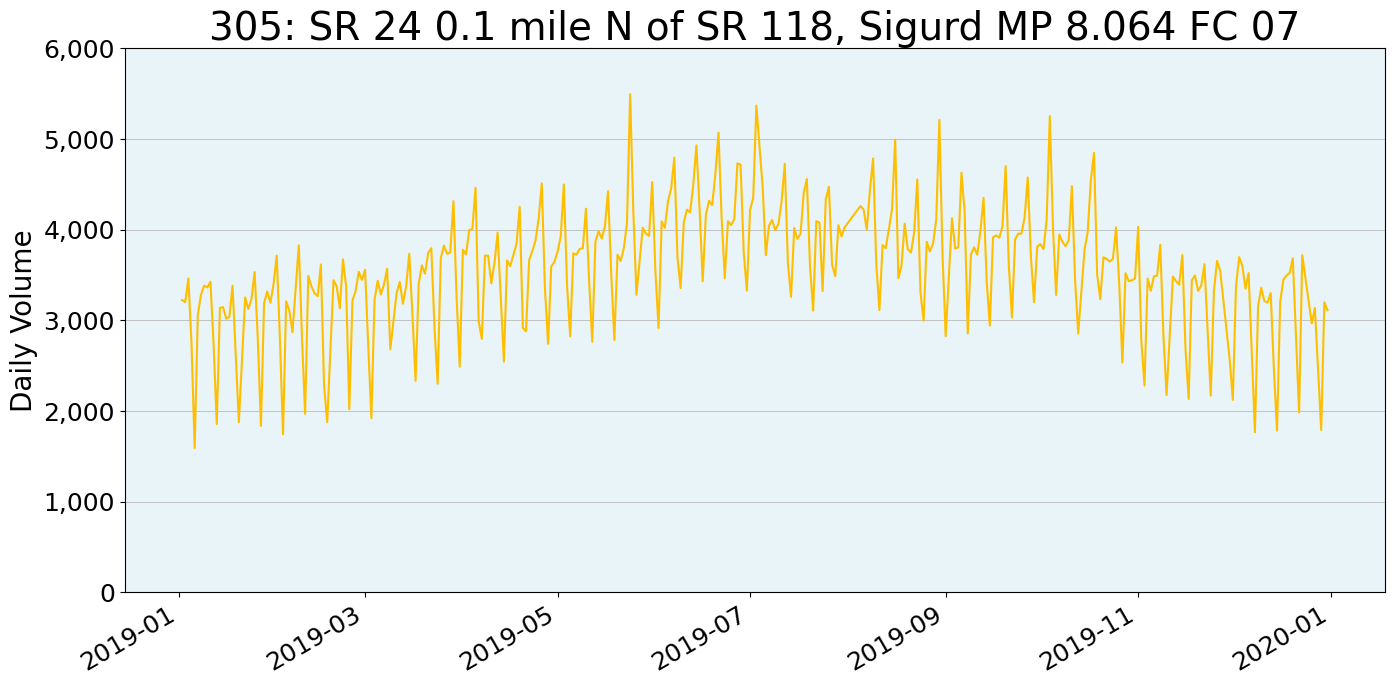

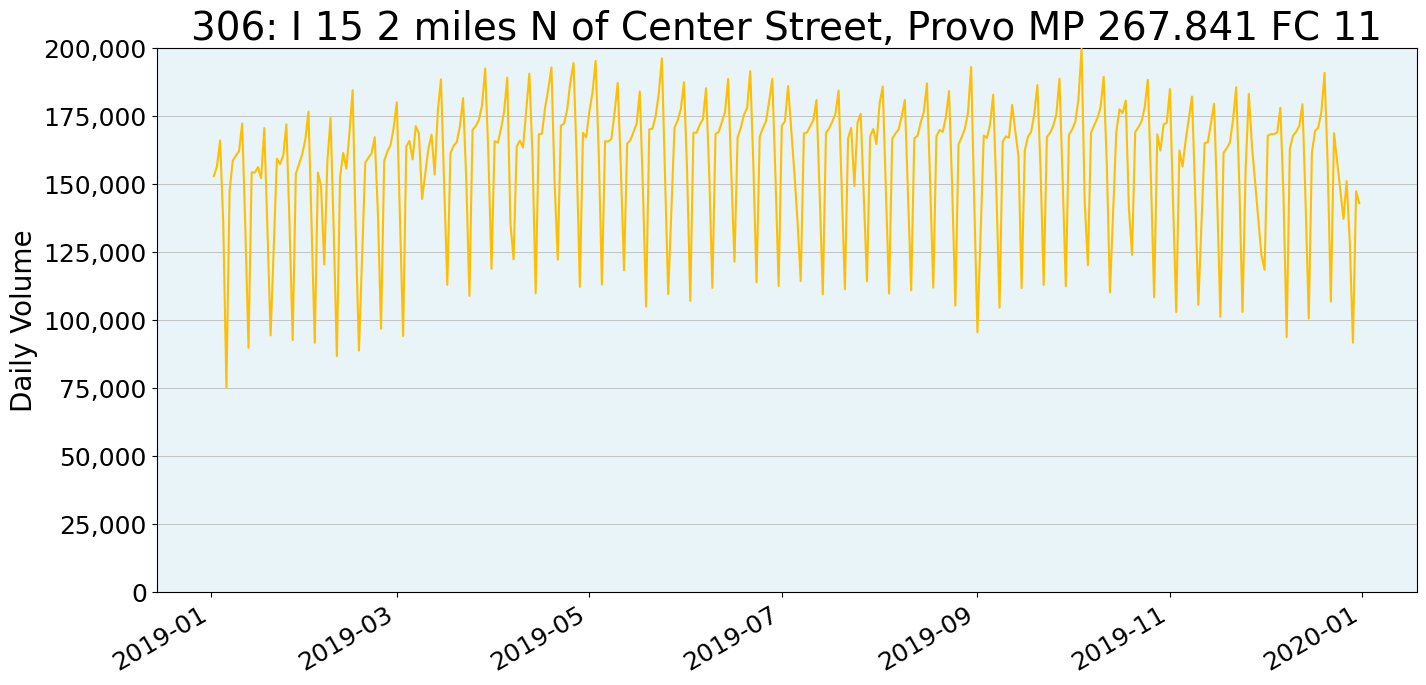

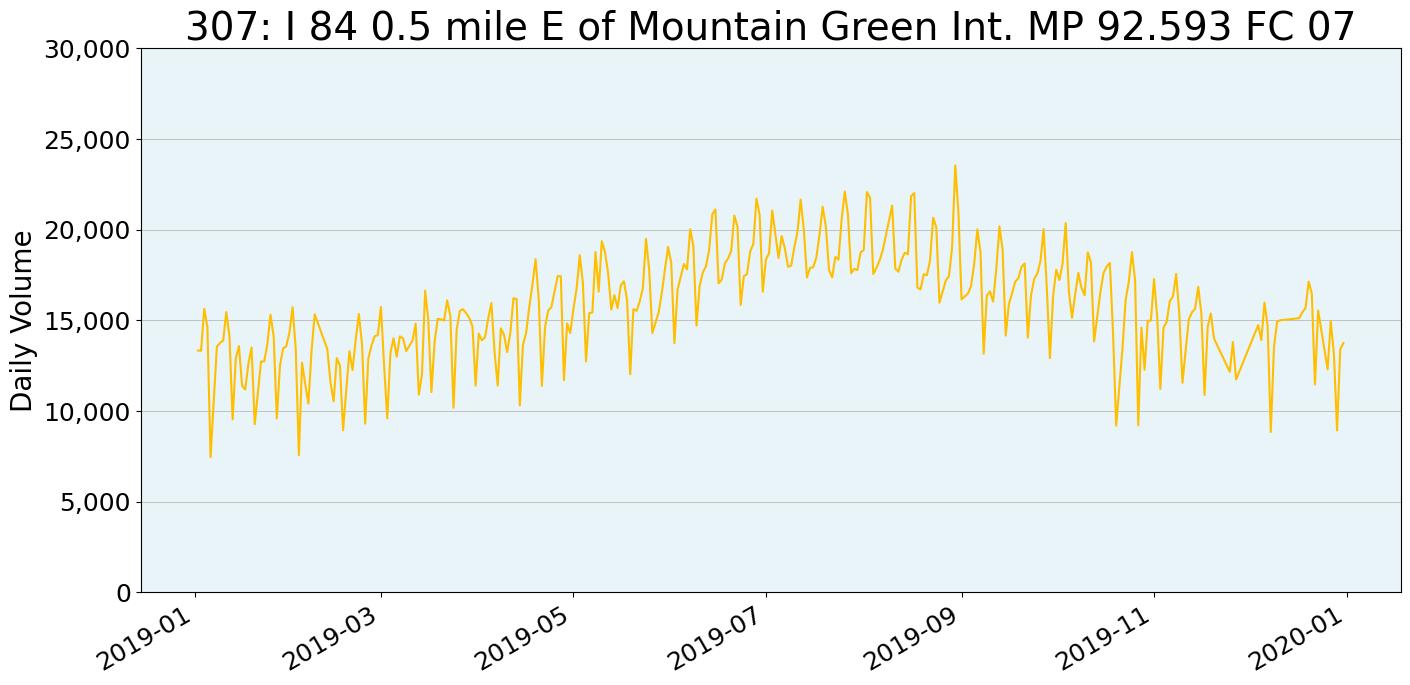

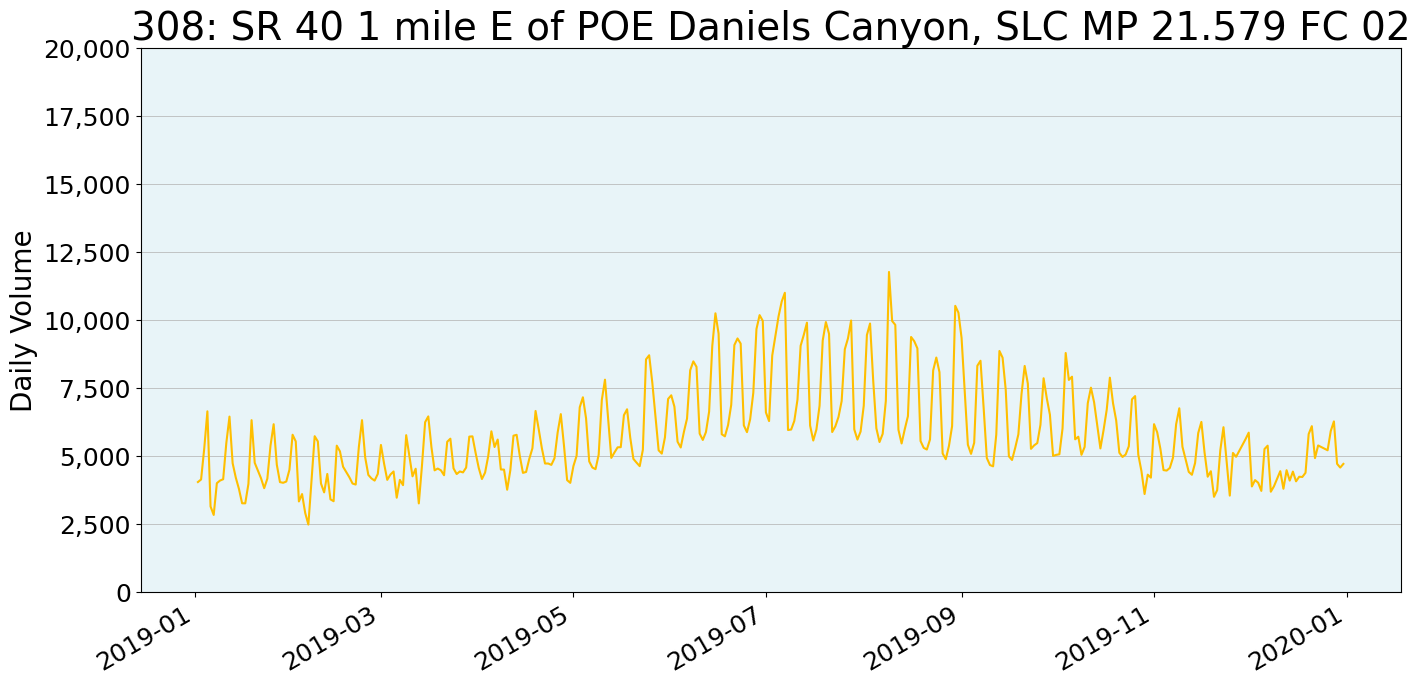

In [332]:
#Make Charts

stations = [304,305,306,307,308]

datefrom = '2019-01-01'
dateto   = '2019-12-31'

for station in stations:
    iStation = station
    dfStationData = prmStationGroups[(prmStationGroups['STATIONGROUP']==str(iStation))]
    sStationName = dfStationData.iloc[0]['STATIONGROUPDESCRIPTION']

    dfPlot = df_CCSDay[(df_CCSDay['STATION']==iStation) & (df_CCSDay['DATE']>=datefrom) & (df_CCSDay['DATE']<=dateto)]
    dfPlot = dfPlot[['DATE','DAYVOL','YEAR']]
    dfPlot = dfPlot.pivot(index='DATE', columns='YEAR', values='DAYVOL')
    #display(dfPlot)

    sLegend = dfPlot.columns.tolist()

    sColors = ["#FFBF00","#FF7F50","#DE3163","#9FE2BF","#40E0D0","#6495ED","#CCCCFF"]

    sBGColor = "#e8f4f8"

    aFigureSize = (18,8)
    iTitleSize = 28
    iLegendSize = 12
    iAxisItemSize = 18
    iAxisTitleSize = 20

    sXAxisLabel = ""
    sYAxisLabel = "Daily Volume"

    ax = dfPlot.plot.line(figsize=aFigureSize, fontsize=iAxisItemSize, color=sColors, zorder=10)

    #set x,y labels
    ax.set_xlabel(sXAxisLabel, fontsize=iAxisTitleSize)
    ax.set_ylabel(sYAxisLabel, fontsize=iAxisTitleSize)

    sTitle = sStationName

    #set title
    ax.set_title(sTitle, fontsize=iTitleSize)
    #add title 
    #display(Markdown("# " + sTitle))

    ax.legend([sLegend], prop=dict(size=iLegendSize));

    ax.grid('on', which='major', axis='y', linestyle='-', linewidth=0.5, zorder=1)

    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

    ax.set_ylim([0, roundup(max(dfPlot.max(axis=1)))])

    ax.set_facecolor (sBGColor)

    # Add a table at the bottom of the axes

    #remove legend
    ax.get_legend().remove()

    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.2, bottom=0.2)
    #plt.xticks([]) #remove x tick labels
